## Propensity Score Matching (Codealong)

We'd like to explore several processes through which we can construct and balance control/exposed groups for observational studies. Here, we will take the following approach:

1) Conduct EDA to understand our dataset AND our exposed groups 

2) Leverage PyMatch to conduct a propensity score match to balance our groups

We'll be following along based on the article below. More information on PyMatch, and this particular dataset, can be found here:
https://medium.com/@bmiroglio/introducing-the-pymatch-package-6a8c020e2009

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Conduct EDA to understand our dataset AND our control/exposed groups

Let's start by reading in our data set and getting a feel for it. We will ultimately build a logistic regression model that will serve as our propensity score match. For this example, we will use whether or not a users loan status is **late/defaulted or paid in full** as our binary target.

In [2]:
df = pd.read_csv('D:/for tish/loan.csv')

C:\Users\Owen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.shape

(2260668, 145)

In [4]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=145)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
member_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,2260668.0,15046.931228,9190.245488,500.00,8000.00,12900.000,20000.0000,40000.00
funded_amnt,2260668.0,15041.664057,9188.413022,500.00,8000.00,12875.000,20000.0000,40000.00
funded_amnt_inv,2260668.0,15023.437624,9192.331807,0.00,8000.00,12800.000,20000.0000,40000.00
...,...,...,...,...,...,...,...,...
hardship_payoff_balance_amount,10613.0,11628.036442,7615.161123,55.73,5628.73,10044.220,16114.9400,40306.41
hardship_last_payment_amount,10613.0,193.606331,198.694368,0.01,43.78,132.890,284.1800,1407.86
settlement_amount,33056.0,5030.606922,3692.027842,44.21,2227.00,4172.855,6870.7825,33601.00
settlement_percentage,33056.0,47.775600,7.336379,0.20,45.00,45.000,50.0000,521.35


Let's arbitrarily cut this down to a more manageable set of columns as this is for illustrative purposes only.

In [6]:
df = df.loc[:,['loan_amnt', 'funded_amnt', 'funded_amnt_inv','term','int_rate', 'installment','grade','sub_grade', 'loan_status']]

We're dealing with a pretty massive dataset here. How is our class balance? Recall we are only looking for "Fully Paid" and "Late/Defaulted" users.

In [7]:
df.loan_status.value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

In [26]:
data.loc[data['loan_status'] == 'Late (31-120 days)', 'loan_status'] = 'Default'

# Sample 20K records from Fully paid and 2K from default
df_alt = data[data.loan_status == 'Fully Paid'].sample(20000, random_state=42) \
    .append(data[data.loan_status == 'Default'].sample(2000, random_state=42))

Our class is going to be massively imbalanced. We'll need to think of a way to account for this. Before moving further, let's see how our classses compare across the features that we retained

In [16]:
df = df.drop(columns={'loan_status'})

In [27]:
test = df_alt[df_alt.loan_status == "Default"]
control = df_alt[df_alt.loan_status == "Fully Paid"]
test['loan_status'] = 1
control['loan_status'] = 0

In [17]:
df_ctrl = df[df.loan_target==0]
df_test = df[df.loan_target==1]

In [18]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,loan_target
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,NaN
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,NaN
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,NaN
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,NaN
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,NaN
...,...,...,...,...,...,...,...,...,...
2260663,12000,12000,12000.0,60 months,14.08,279.72,C,C3,NaN
2260664,12000,12000,12000.0,60 months,25.82,358.01,E,E4,0.0
2260665,10000,10000,10000.0,36 months,11.99,332.10,B,B5,NaN
2260666,12000,12000,12000.0,60 months,21.45,327.69,D,D5,NaN


Looking across out predictors, it appears that 'term' in particular is showing some imbalance between our groups. You can also see that our supgroups and groups have different ordering, indicating imbalance as well.

Let's see if we can leverage PyMatch here to assist with balancing.

In [20]:
import warnings
warnings.filterwarnings('ignore')
from pymatch.Matcher import Matcher

In [28]:
m = Matcher(test, control, yvar="loan_status", exclude=[])

Formula:
loan_status ~ loan_amnt+funded_amnt+funded_amnt_inv+term+int_rate+installment+grade+sub_grade
n majority: 20000
n minority: 2000


In [29]:
np.random.seed(20170925)

m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 65.99%


What PyMatch is doing here is generating a series of logistic regression models that will assign probabilities for our target at the user level. From here, we can look at the relatively probabilities for our control and test group in a visual way below

In [33]:
m.predict_scores()

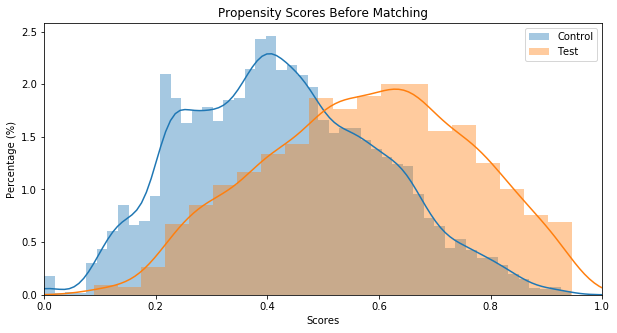

In [34]:
m.plot_scores()

You can see that the distributions are not in exact alignment. From here, we can determine a threshold that we'd like to hit in terms of probabilities for matching our control and test groups. In essence, this threshold will let us find like users that have not defaulted. In order to do this, we can look at an elbow plot of threshold values relative to the data we retain.

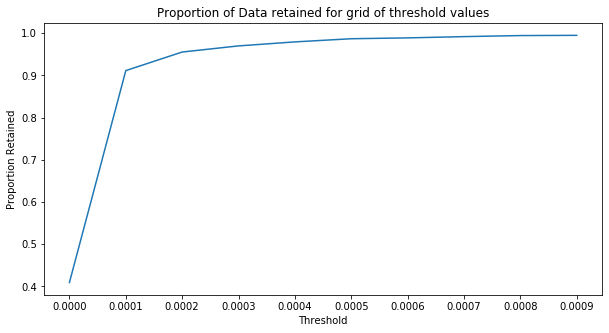

In [40]:
m.tune_threshold(method='random')

From the above, 0.0002 looks like a viable threshold. We'll retain the majority of our records. Let's call the .match() function against our dataset. Again, PyMatch works by

In [46]:
m.match(method="min", nmatches=1, threshold=0.0002)
m.record_frequency()


,freq,n_records
0,1,3192
1,2,237
2,3,58
3,4,26
4,5,4
5,6,3
6,7,1
7,11,1


In [42]:
m.assign_weight_vector()

In [43]:
m.matched_data.sort_values("match_id").head(6)

,record_id,weight,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,loan_status,scores,match_id
0,0,1.0,12000,12000,12000.0,60 months,12.59,270.53,C,C2,1,0.568136,0
2411,6238,1.0,2500,2500,2500.0,36 months,18.85,91.46,D,D3,0,0.568134,0
1,1,1.0,15000,15000,15000.0,36 months,10.75,489.31,B,B4,1,0.345629,1
2778,10360,1.0,15000,15000,15000.0,36 months,10.75,489.31,B,B4,0,0.345629,1
2,2,1.0,30000,30000,30000.0,36 months,6.49,919.34,A,A2,1,0.238167,2
3738,19367,1.0,9600,9600,9600.0,36 months,6.97,296.29,A,A3,0,0.238166,2


We now have out match populations. Let's determine now if our data is "balanced" across our covariates.

### Categorical

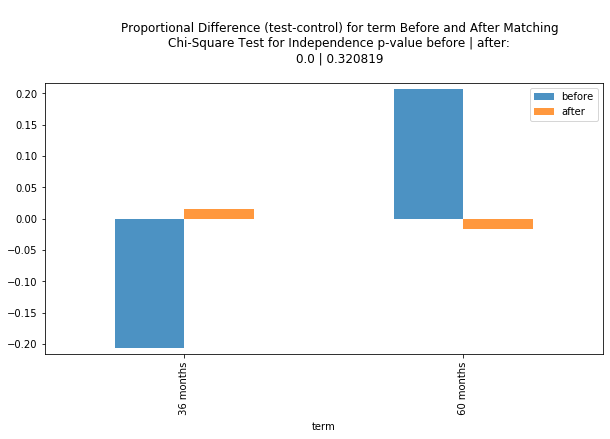

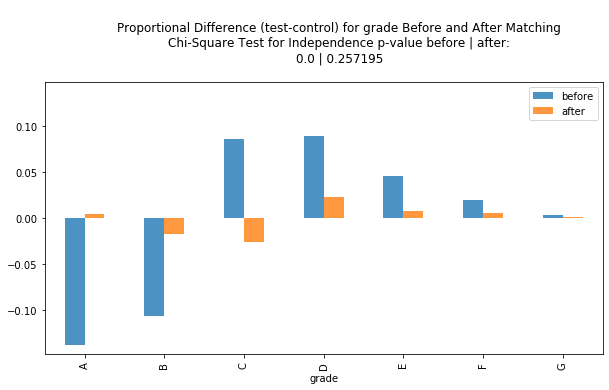

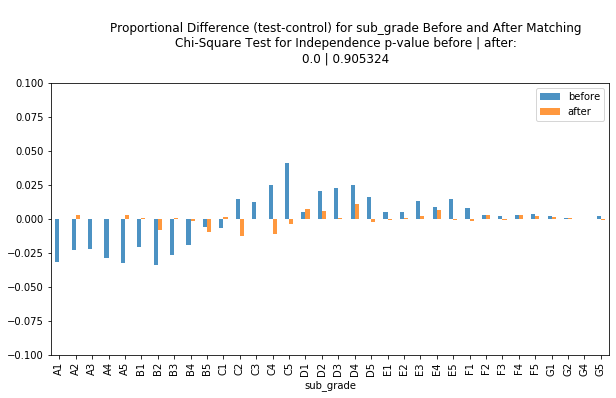

In [49]:
categorical_results = m.compare_categorical(return_table=True)

Looking at the resultant distributions, you can see how the orane bars are much smaller across the board than the blue bars. This means that our propensity match has succesfully minimized the differences between our populations. Let's now move into continuous variables.

### Continuous

To make these comparisons, we'll leverage CDF EDA for our test and control groups. Here, we are looking for near identical CDFs. There are a couple of approaches we can use to verify closeness of our distributions. 

 - Kolmogorov-Smirnov Test (KS): This tests whether or not two distributions are different at a statistically significant level
 - Chi-Square Distance: A similar test for similarly binned histograms.
 - Std Mean / Med differences: we can also look at std deviations are between mean/median for our groups.

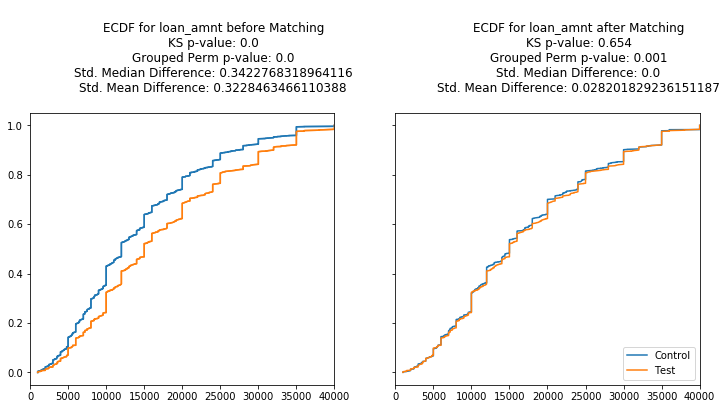

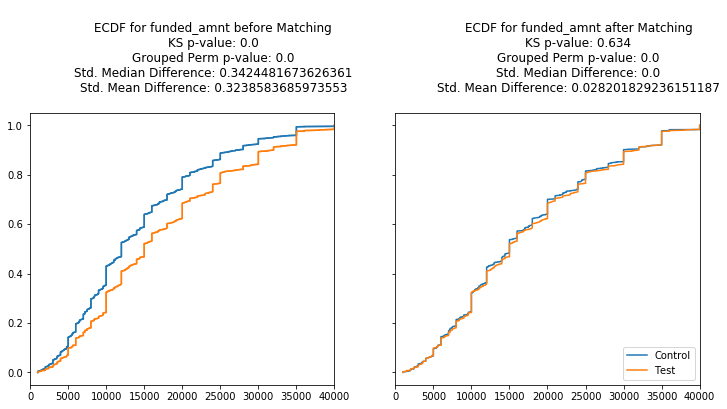

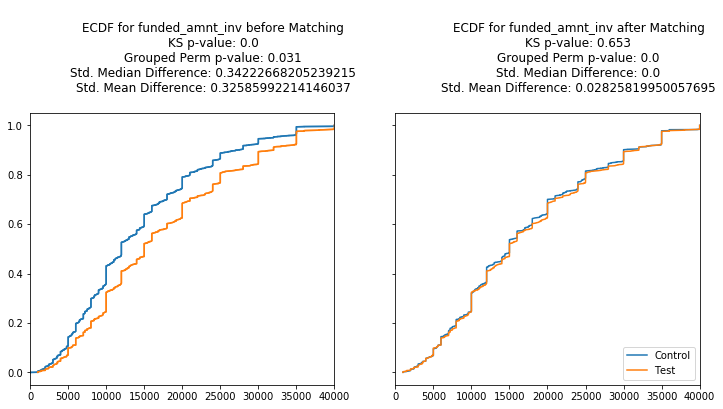

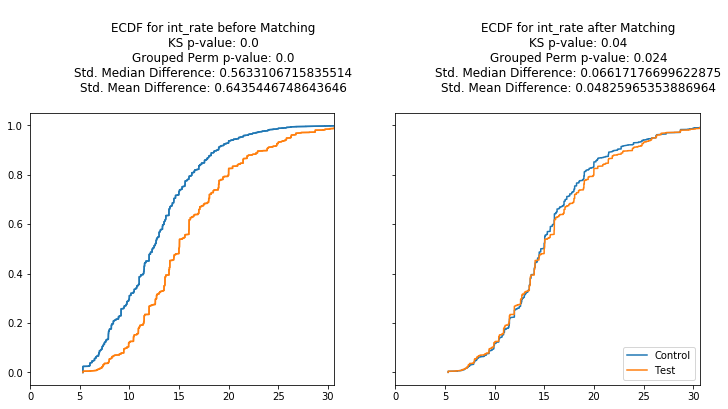

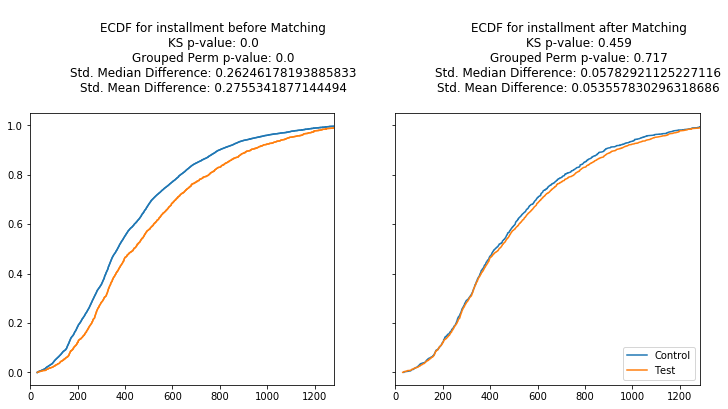

In [50]:
cc = m.compare_continuous(return_table=True)

Our KS p-values and Chi Square Distane p-values are all > 0.05, so we have effectively balanced our groups.

### Sample Applications

This python library (or MatchIt in R) is an effective way of dealing with observational studies. In situations, where you have an exposed group, and need to model a control group, you often need to leverage propensity modeling to find like non-exposed users/households to model lift. A great example of this would be modeling the impact of TV exposure-- it is costly and inefficient to design a test prior to evaluation, so you do not have the benefit of a holdout. Here, you can approximate it as best as possible, while also balancing your covariates.